In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt


In [ ]:
# =============================
# 2. Поиск всех CSV в NAB
# =============================
DATA_ROOT = "/kaggle/input/nab"

csv_files = []
for root, dirs, files in os.walk(DATA_ROOT):
    for f in files:
        if f.endswith(".csv"):
            csv_files.append(os.path.join(root, f))

print("Найдено файлов:", len(csv_files))
print(csv_files[:10])

Найдено файлов: 60
['/kaggle/input/nab/realKnownCause/realKnownCause/rogue_agent_key_updown.csv', '/kaggle/input/nab/realKnownCause/realKnownCause/ec2_request_latency_system_failure.csv', '/kaggle/input/nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv', '/kaggle/input/nab/realKnownCause/realKnownCause/nyc_taxi.csv', '/kaggle/input/nab/realKnownCause/realKnownCause/rogue_agent_key_hold.csv', '/kaggle/input/nab/realKnownCause/realKnownCause/machine_temperature_system_failure.csv', '/kaggle/input/nab/realKnownCause/realKnownCause/cpu_utilization_asg_misconfiguration.csv', '/kaggle/input/nab/realTraffic/realTraffic/TravelTime_387.csv', '/kaggle/input/nab/realTraffic/realTraffic/speed_6005.csv', '/kaggle/input/nab/realTraffic/realTraffic/speed_t4013.csv']


In [ ]:
# =============================
# 3. Выбор одного файла
# =============================
FILE_IDX = 0   # можно менять
file_path = csv_files[FILE_IDX]
print("Используем файл:", file_path)

df = pd.read_csv(file_path)
print(df.head())

Используем файл: /kaggle/input/nab/realKnownCause/realKnownCause/rogue_agent_key_updown.csv
             timestamp     value
0  2014-07-06 20:10:00  1.047256
1  2014-07-06 20:15:00  1.848031
2  2014-07-06 20:20:00  1.297892
3  2014-07-06 20:25:00  1.593151
4  2014-07-06 20:35:00  0.000000


In [ ]:
# =============================
# 4. Приведение к формату time/value
# =============================
value_col = df.columns[-1]   # последняя колонка = значение
values = df[value_col].values.astype(float)

In [ ]:
# =============================
# 5. Нормализация
# =============================
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()


In [ ]:
# =============================
# 6. Функция создания окон
# =============================
WINDOW_SIZE = 50

def create_windows(sequence, window):
    X = []
    for i in range(len(sequence) - window):
        X.append(sequence[i:i+window])
    return np.array(X)

samples = create_windows(values_scaled, WINDOW_SIZE)
print("Создано окон:", len(samples))

# Проверка
if len(samples) == 0:
    raise ValueError("Окон = 0. Уменьши WINDOW_SIZE.")


Создано окон: 5265


In [ ]:

# =============================
# 7. Dataset
# =============================
class WindowsDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]

dataset = WindowsDataset(samples)
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)


In [ ]:
# =============================
# 8. Модель LSTM Autoencoder
# =============================
class LSTMAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, latent_dim, batch_first=True)
        self.decoder = nn.LSTM(latent_dim, input_dim, batch_first=True)

    def forward(self, x):
        z, _ = self.encoder(x)
        out, _ = self.decoder(z)
        return out

model = LSTMAE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# =============================
# 9. Обучение
# =============================
EPOCHS = 30
losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for x in loader:
        x = x.unsqueeze(-1)  # (batch, window, 1)
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {epoch_loss:.5f}")


Epoch 1/30  Loss: 0.12072
Epoch 2/30  Loss: 0.01489
Epoch 3/30  Loss: 0.01277
Epoch 4/30  Loss: 0.01171
Epoch 5/30  Loss: 0.01072
Epoch 6/30  Loss: 0.01012
Epoch 7/30  Loss: 0.00953
Epoch 8/30  Loss: 0.00898
Epoch 9/30  Loss: 0.00849
Epoch 10/30  Loss: 0.00790
Epoch 11/30  Loss: 0.00752
Epoch 12/30  Loss: 0.00701
Epoch 13/30  Loss: 0.00647
Epoch 14/30  Loss: 0.00591
Epoch 15/30  Loss: 0.00530
Epoch 16/30  Loss: 0.00463
Epoch 17/30  Loss: 0.00403
Epoch 18/30  Loss: 0.00340
Epoch 19/30  Loss: 0.00280
Epoch 20/30  Loss: 0.00230
Epoch 21/30  Loss: 0.00190
Epoch 22/30  Loss: 0.00162
Epoch 23/30  Loss: 0.00142
Epoch 24/30  Loss: 0.00125
Epoch 25/30  Loss: 0.00117
Epoch 26/30  Loss: 0.00110
Epoch 27/30  Loss: 0.00105
Epoch 28/30  Loss: 0.00101
Epoch 29/30  Loss: 0.00098
Epoch 30/30  Loss: 0.00095


In [ ]:
# =============================
# 10. Reconstruction Error (все окна)
# =============================
model.eval()
with torch.no_grad():
    X = torch.tensor(samples, dtype=torch.float32).unsqueeze(-1)
    recon = model(X)
    errors = ((recon.squeeze() - X.squeeze())**2).mean(dim=1).numpy()

print("Errors shape:", errors.shape)


Errors shape: (5265,)


In [ ]:
# =============================
# 11. Получаем бинарные true labels (если есть)
# =============================
label_file = file_path.replace("data", "labels").replace(".csv", ".labels")
if os.path.exists(label_file):
    labels_df = pd.read_csv(label_file)
    labels = labels_df.iloc[:, -1].values[-len(errors):]
else:
    print("Labels not found — создаем всё как normal.")
    labels = np.zeros(len(errors))


Labels not found — создаем всё как normal.


In [ ]:
# =============================
# 12. Порог через ROC-AUC
# =============================
threshold = np.percentile(errors, 95)
preds = (errors > threshold).astype(int)

# Метрики
precision = precision_score(labels, preds, zero_division=0)
recall = recall_score(labels, preds, zero_division=0)
f1 = f1_score(labels, preds, zero_division=0)
acc = accuracy_score(labels, preds)
roc = roc_auc_score(labels, errors) if len(np.unique(labels)) > 1 else 0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)

# =============================================================
# 1. y_true и y_pred
# =============================================================
y_true = labels
y_pred = preds

min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

print("y_true length:", len(y_true))
print("y_pred length:", len(y_pred))

# =============================================================
# 2. Confusion matrix (устойчива даже если один класс отсутствует)
# =============================================================

# Если один класс отсутствует → создаём полный CM вручную
unique_true = set(np.unique(y_true)) | set(np.unique(y_pred))
if unique_true == {0,1}:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
else:
    # Создаем безопасную матрицу
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # cm всегда будет 2x2
    tn, fp, fn, tp = cm.ravel()

# =============================================================
# 3. Метрики с обработкой edge cases
# =============================================================

def safe_metric(func, *args):
    try:
        return func(*args)
    except:
        return np.nan

# class-wise metrics
prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=[0,1], zero_division=0
)

precision_0, precision_1 = prec
recall_0, recall_1 = rec
f1_0, f1_1 = f1
support_0, support_1 = sup

accuracy = accuracy_score(y_true, y_pred)

roc = safe_metric(roc_auc_score, y_true, y_pred)

specificity = tn / (tn + fp) if (tn+fp) > 0 else np.nan
balanced = (recall_1 + specificity) / 2 if specificity is not np.nan else np.nan

report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# =============================================================
# 4. Подробная таблица метрик
# =============================================================

metrics_df = pd.DataFrame([
    ["TN", tn],
    ["FP", fp],
    ["FN", fn],
    ["TP", tp],

    ["Precision (class 0)", precision_0],
    ["Precision (class 1)", precision_1],
    ["Recall (class 0)", recall_0],
    ["Recall (class 1)", recall_1],
    ["F1-score (class 0)", f1_0],
    ["F1-score (class 1)", f1_1],
    ["Support (class 0)", support_0],
    ["Support (class 1)", support_1],

    ["Accuracy", accuracy],
    ["ROC-AUC", roc],
    ["Specificity (TNR)", specificity],
    ["Balanced Accuracy", balanced],

    ["Macro Precision", report["macro avg"]["precision"]],
    ["Macro Recall", report["macro avg"]["recall"]],
    ["Macro F1", report["macro avg"]["f1-score"]],
    ["Weighted Precision", report["weighted avg"]["precision"]],
    ["Weighted Recall", report["weighted avg"]["recall"]],
    ["Weighted F1", report["weighted avg"]["f1-score"]],
])

metrics_df.columns = ["Metric", "Value"]
print(metrics_df)


y_true length: 5265
y_pred length: 5265
                 Metric        Value
0                    TN  5001.000000
1                    FP   264.000000
2                    FN     0.000000
3                    TP     0.000000
4   Precision (class 0)     1.000000
5   Precision (class 1)     0.000000
6      Recall (class 0)     0.949858
7      Recall (class 1)     0.000000
8    F1-score (class 0)     0.974284
9    F1-score (class 1)     0.000000
10    Support (class 0)  5265.000000
11    Support (class 1)     0.000000
12             Accuracy     0.949858
13              ROC-AUC          NaN
14    Specificity (TNR)     0.949858
15    Balanced Accuracy     0.474929
16      Macro Precision     0.500000
17         Macro Recall     0.474929
18             Macro F1     0.487142
19   Weighted Precision     1.000000
20      Weighted Recall     0.949858
21          Weighted F1     0.974284


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
anomaly_times = df.iloc[np.where(aligned_preds==1)][["timestamp", value_col]]
anomaly_times.head()


,timestamp,value
595,2014-07-08 22:10:00,0.000000
596,2014-07-08 22:15:00,11.422946
597,2014-07-08 22:20:00,6.178202
598,2014-07-08 22:25:00,0.000000
599,2014-07-08 22:30:00,1.437417


from matplotlib import pyplot as plt
_df_0['value'].plot(kind='hist', bins=20, title='value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('timestamp').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['value'].plot(kind='line', figsize=(8, 4), title='value')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['timestamp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='value', y='timestamp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['value'].plot(kind='hist', bins=20, title='value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_8.groupby('timestamp').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='index', y='value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_14['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['value'].plot(kind='line', figsize=(8, 4), title='value')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['timestamp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='timestamp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['timestamp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='value', y='timestamp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

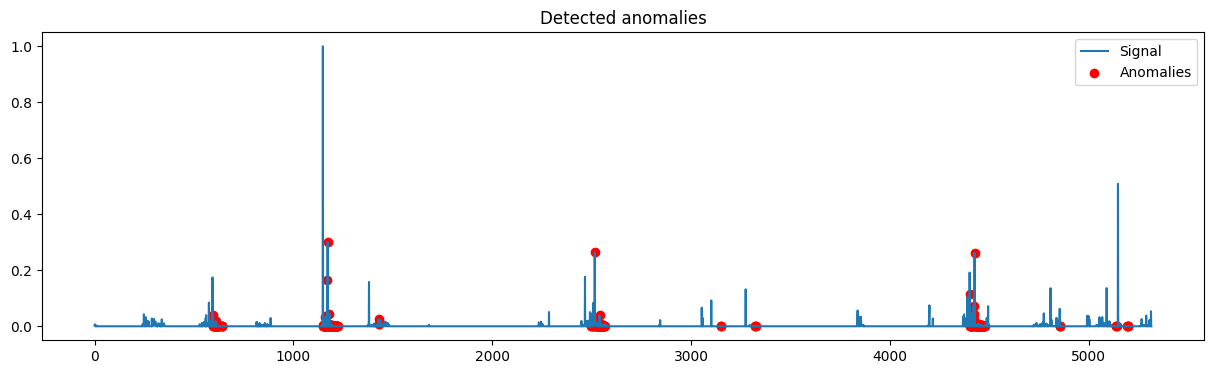

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(values_scaled, label="Signal")
plt.scatter(np.where(aligned_preds==1), values_scaled[aligned_preds==1], color='red', label="Anomalies")
plt.title("Detected anomalies")
plt.legend()
plt.show()


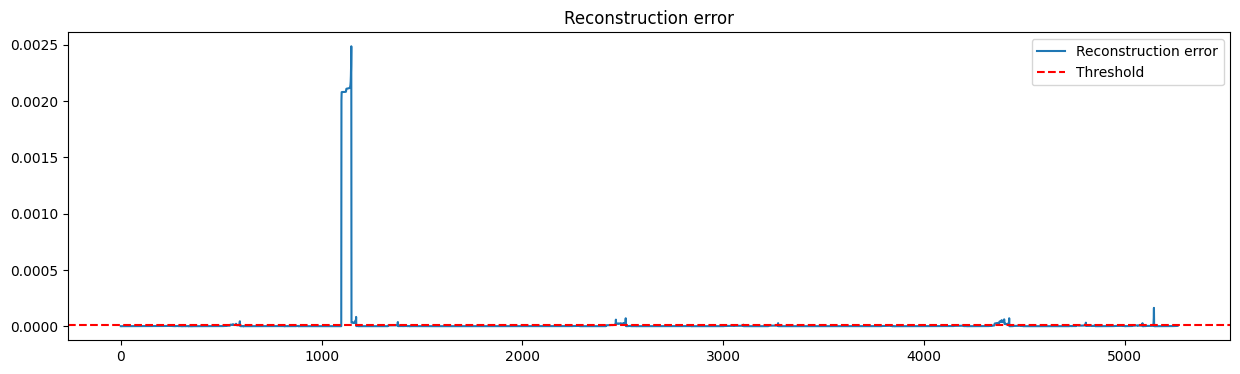

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(errors, label="Reconstruction error")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.title("Reconstruction error")
plt.legend()
plt.show()


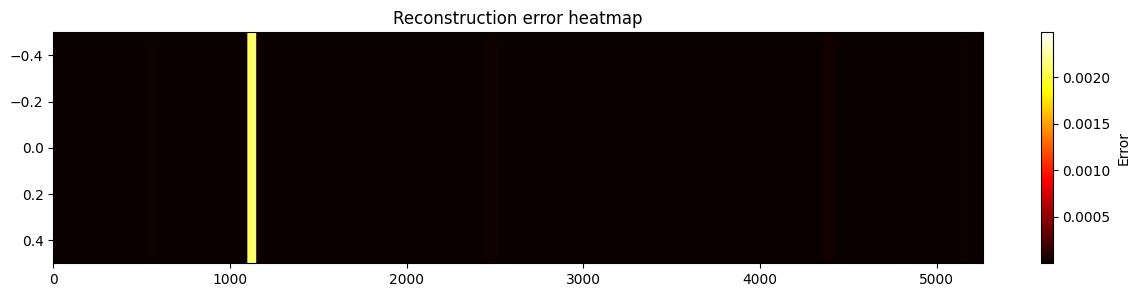

In [ ]:
plt.figure(figsize=(15,3))
plt.imshow(errors.reshape(1, -1), aspect="auto", cmap="hot")
plt.colorbar(label="Error")
plt.title("Reconstruction error heatmap")
plt.show()
